In [ ]:
### importando pacotes e 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import optuna
from darts.metrics import mape,mae,mse
from darts.timeseries import TimeSeries

C:\Users\aryck\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist,extract_trend_and_seasonality
from darts.utils.utils import SeasonalityMode
import logging
from darts.utils.utils import ModelMode
from darts.utils.utils import TrendMode
from darts.models import Prophet
from darts.dataprocessing.transformers import Scaler

## EDA

In [6]:
import pickle
with open("../../SRAG_time_series/series_weekly_SRAG.pkl", "rb") as f:
    series_weekly = pickle.load(f)

<Axes: xlabel='Year_Week'>

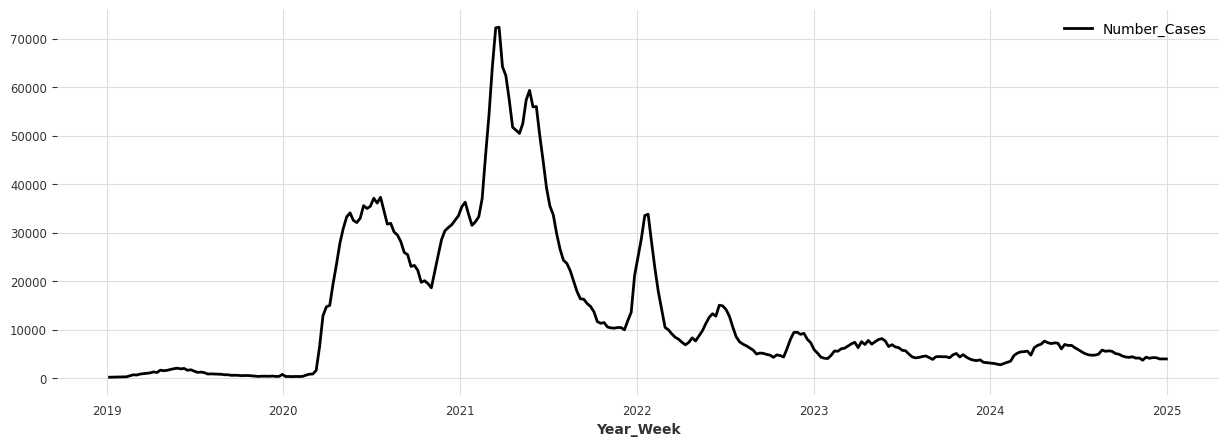

In [11]:
from scipy.stats import fit
from scipy.stats import fit
from scipy.stats import norm, lognorm

fig, ax = plt.subplots(figsize=(15, 5))
series_weekly.plot()

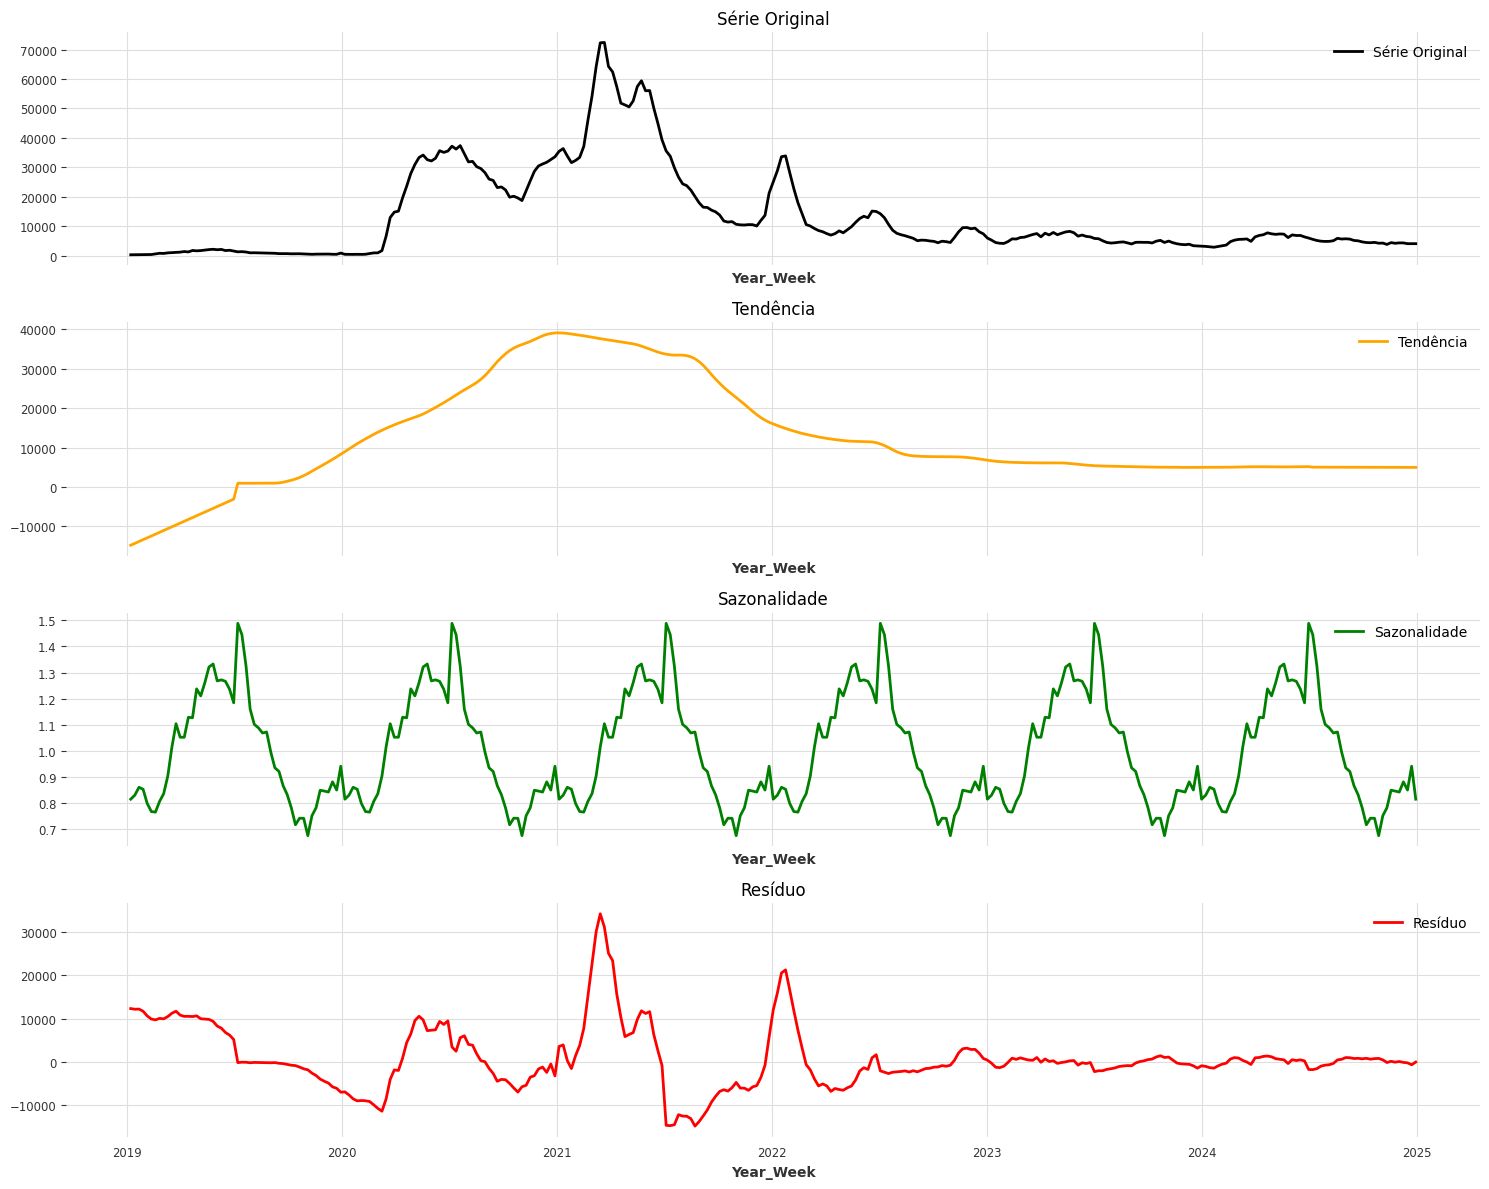

In [12]:
import matplotlib.pyplot as plt

series_trend, series_seasonality = extract_trend_and_seasonality(series_weekly, model=ModelMode.MULTIPLICATIVE)
reconstructed = series_trend * series_seasonality
series_residual = series_weekly - reconstructed

# Criar subplots
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

# Plot da série original
series_weekly.plot(ax=axes[0], label="Série Original")
axes[0].set_title("Série Original")
axes[0].legend()

# Plot da tendência
series_trend.plot(ax=axes[1], label="Tendência", color="orange")
axes[1].set_title("Tendência")
axes[1].legend()

# Plot da sazonalidade
series_seasonality.plot(ax=axes[2], label="Sazonalidade", color="green")
axes[2].set_title("Sazonalidade")
axes[2].legend()

# Plot do resíduo
series_residual.plot(ax=axes[3], label="Resíduo", color="red")
axes[3].set_title("Resíduo")
axes[3].legend()

# Ajustar o layout
plt.tight_layout()
plt.show()

## Prophet

In [15]:
# Realizando o split
train, val = series_weekly.split_before(0.83)

### Setup de treinamento utilizando OPTUNA 

In [28]:
from prophet import Prophet  # Facebook's Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error

In [36]:
# For older Darts versions
train_df = pd.DataFrame({
    "ds": train.time_index,  # Gets the datetime index
    "y": train.univariate_values()  # Gets the values
})

val_df = pd.DataFrame({
    "ds": val.time_index,
    "y": val.univariate_values()
})

df = pd.DataFrame({
    "ds": series_weekly.time_index,
    "y": series_weekly.univariate_values()
})

In [62]:
def objective(trial):
    # Hiperparâmetros a serem otimizados
    params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.01, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 5, 20),
        'weekly_seasonality': trial.suggest_int('weekly_seasonality', 3, 10),
    }
    
    # Criar e treinar o modelo
    model = Prophet(**params)
    model.fit(train_df)

        # Fazer previsão no conjunto de teste
    future = model.make_future_dataframe(periods=len(val_df))
    forecast = model.predict(future)
    
    # Calcular RMSE
    y_true = val_df['y'].values
    y_pred = forecast.tail(len(val_df))['yhat'].values
    rmse = mean_squared_error(y_true, y_pred)
    
    return rmse


In [33]:
study = optuna.create_study(direction='minimize')  # Queremos minimizar o RMSE
study.optimize(objective, n_trials=50)  # Testar 50 combinações de parâmetros

# Melhores parâmetros encontrados
print("Melhores parâmetros:", study.best_params)

[I 2025-05-14 20:07:43,144] A new study created in memory with name: no-name-9990d4f7-b26e-4f8a-b1f8-e2ba10b46fb1
20:07:43 - cmdstanpy - INFO - Chain [1] start processing
20:07:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-05-14 20:07:43,645] Trial 0 finished with value: 15001092.911832675 and parameters: {'changepoint_prior_scale': 0.13312381125241476, 'seasonality_prior_scale': 0.7528749337594116, 'holidays_prior_scale': 2.429855238884571, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 7}. Best is trial 0 with value: 15001092.911832675.
20:07:43 - cmdstanpy - INFO - Chain [1] start processing
20:07:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-05-14 20:07:43,852] Trial 1 finished with value: 26773622.842987567 and parameters: {'changepoint_prior_scale': 0.1504182164390991, 'seasonality_prior_scale': 7.227828785418832, 'holidays_prior_scale': 8.606878396643907, 'seasonality_mode': 'additive', 'yearly_seasonality': 13, 'wee

Melhores parâmetros: {'changepoint_prior_scale': 0.4663957084103698, 'seasonality_prior_scale': 1.2734388948371018, 'holidays_prior_scale': 7.160018639166438, 'seasonality_mode': 'additive', 'yearly_seasonality': 6, 'weekly_seasonality': 4}


In [37]:
best_params = study.best_params

model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    yearly_seasonality=best_params['yearly_seasonality'],
    weekly_seasonality=best_params['weekly_seasonality'],
)

model.fit(df)

20:10:04 - cmdstanpy - INFO - Chain [1] start processing
20:10:04 - cmdstanpy - INFO - Chain [1] done processing


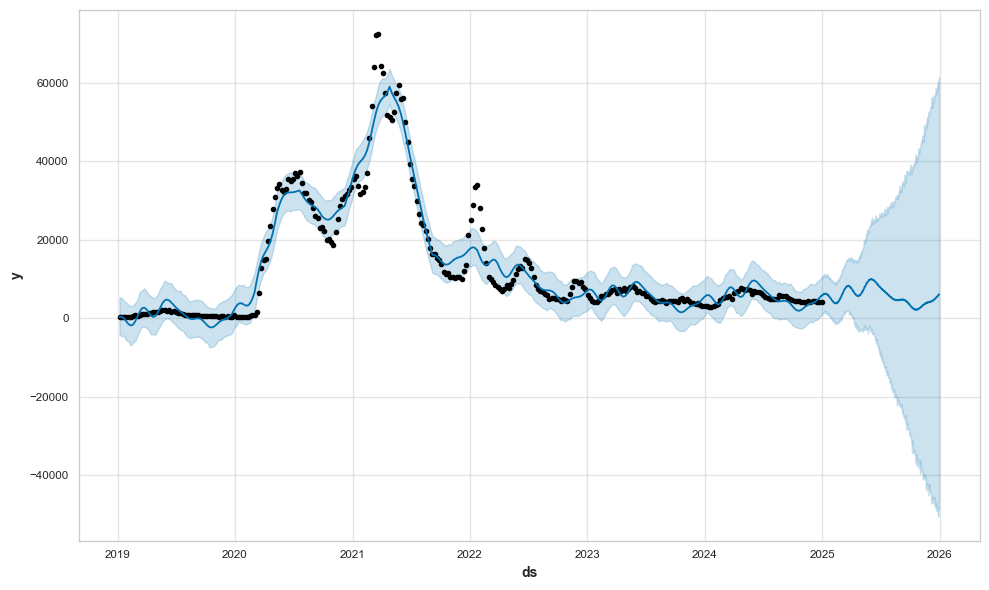

In [53]:
future = model.make_future_dataframe(periods=365)  # Prever 1 ano à frente
forecast = model.predict(future)

# Visualizar previsão
fig = model.plot(forecast)
plt.show()

In [54]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-07,-452.741254,-4188.219883,5225.529163,-452.741254,-452.741254,795.428755,795.428755,795.428755,112.560263,112.560263,112.560263,682.868492,682.868492,682.868492,0.0,0.0,0.0,342.687501
1,2019-01-14,-413.636705,-4531.184041,5215.838243,-413.636705,-413.636705,806.391317,806.391317,806.391317,112.560263,112.560263,112.560263,693.831055,693.831055,693.831055,0.0,0.0,0.0,392.754613
2,2019-01-21,-374.532155,-4471.268596,4436.017699,-374.532155,-374.532155,355.741806,355.741806,355.741806,112.560263,112.560263,112.560263,243.181543,243.181543,243.181543,0.0,0.0,0.0,-18.790350
3,2019-01-28,-335.427606,-5635.105162,3975.903202,-335.427606,-335.427606,-409.025284,-409.025284,-409.025284,112.560263,112.560263,112.560263,-521.585547,-521.585547,-521.585547,0.0,0.0,0.0,-744.452890
4,2019-02-04,-296.323056,-5924.269690,3443.738312,-296.323056,-296.323056,-1176.341098,-1176.341098,-1176.341098,112.560263,112.560263,112.560263,-1288.901361,-1288.901361,-1288.901361,0.0,0.0,0.0,-1472.664154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,2025-12-26,5880.017907,-49258.848148,59784.409101,-48162.298961,59656.417752,-175.366815,-175.366815,-175.366815,-20.332319,-20.332319,-20.332319,-155.034496,-155.034496,-155.034496,0.0,0.0,0.0,5704.651092
674,2025-12-27,5881.110825,-50013.145615,60425.404137,-48340.999595,59867.868554,-59.176778,-59.176778,-59.176778,3.475406,3.475406,3.475406,-62.652184,-62.652184,-62.652184,0.0,0.0,0.0,5821.934047
675,2025-12-28,5882.203743,-50542.984493,60744.173525,-48510.837224,60079.319357,-11.297412,-11.297412,-11.297412,-39.423409,-39.423409,-39.423409,28.125997,28.125997,28.125997,0.0,0.0,0.0,5870.906331
676,2025-12-29,5883.296661,-47977.320192,59383.375364,-48680.688825,60290.770159,229.138799,229.138799,229.138799,112.560263,112.560263,112.560263,116.578536,116.578536,116.578536,0.0,0.0,0.0,6112.435460


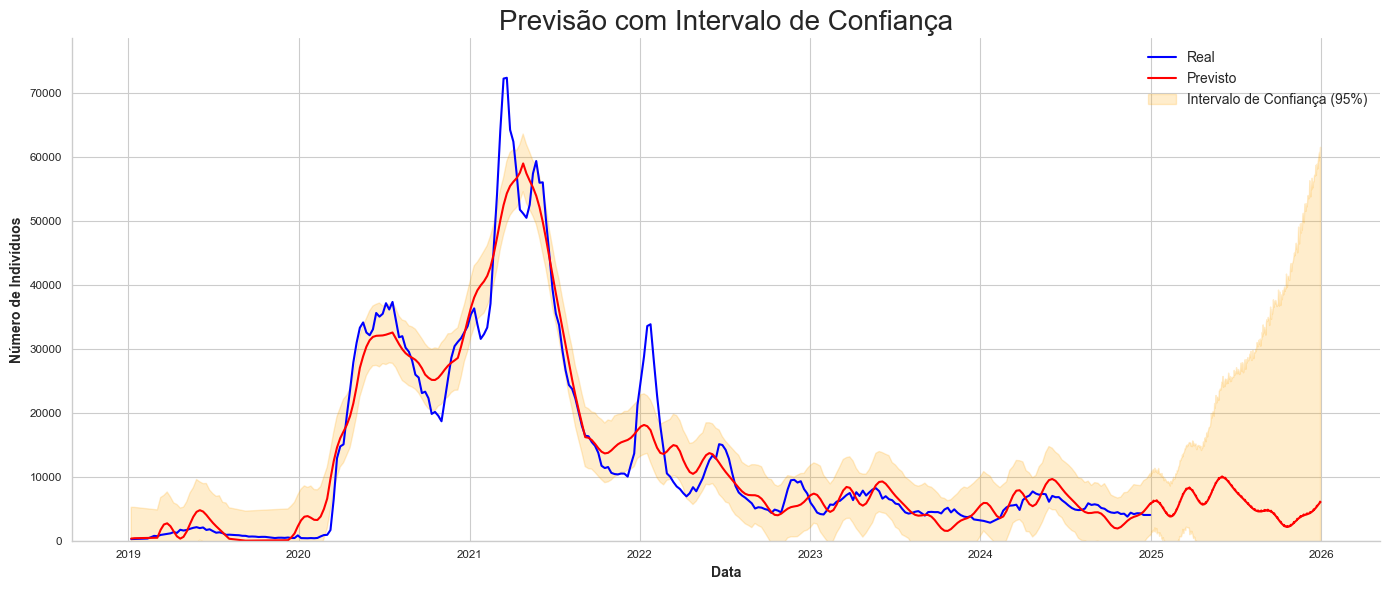

In [58]:
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# Plotar dados reais
sns.lineplot(data=df, x='ds', y='y', label="Real", color='blue', linewidth=1.5)

# Plotar previsões (apenas positivas)
sns.lineplot(data=forecast_filtered, x='ds', y='yhat', label="Previsto", color='red', linewidth=1.5)

# Preencher intervalo de confiança (80% e 95%)
plt.fill_between(
    forecast_filtered['ds'],
    forecast_filtered['yhat_lower'],
    forecast_filtered['yhat_upper'],
    color='orange',
    alpha=0.2,
    label="Intervalo de Confiança (95%)"
)

# Mostrar apenas valores positivos no eixo y
plt.ylim(bottom=0)

plt.title("Previsão com Intervalo de Confiança", fontsize=20)
plt.xlabel("Data")
plt.ylabel("Número de Indivíduos")
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

#### Outra abordagem: minimizar o MAPE

In [63]:
def objective_2(trial):
    # Hiperparâmetros a serem otimizados
    params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.01, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 5, 20),
        'weekly_seasonality': trial.suggest_int('weekly_seasonality', 3, 10),
    }
    
    # Criar e treinar o modelo
    model = Prophet(**params)
    model.fit(train_df)

        # Fazer previsão no conjunto de teste
    future = model.make_future_dataframe(periods=len(val_df))
    forecast = model.predict(future)
    
    # Calcular RMSE
    y_true = val_df['y'].values
    y_pred = forecast.tail(len(val_df))['yhat'].values
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    return mape

In [64]:
study2 = optuna.create_study(direction='minimize')  # Queremos minimizar o RMSE
study2.optimize(objective_2, n_trials=200)  # Testar 50 combinações de parâmetros

# Melhores parâmetros encontrados
print("Melhores parâmetros:", study.best_params)

[I 2025-05-15 00:38:02,726] A new study created in memory with name: no-name-6895ffb8-dcc4-45d4-be3f-ac2da6002bd4
00:38:03 - cmdstanpy - INFO - Chain [1] start processing
00:38:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-05-15 00:38:04,181] Trial 0 finished with value: 1.0048331207320924 and parameters: {'changepoint_prior_scale': 0.015630013986664845, 'seasonality_prior_scale': 4.788191847262495, 'holidays_prior_scale': 9.404066140558003, 'seasonality_mode': 'additive', 'yearly_seasonality': 8, 'weekly_seasonality': 9}. Best is trial 0 with value: 1.0048331207320924.
00:38:04 - cmdstanpy - INFO - Chain [1] start processing
00:38:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-05-15 00:38:04,642] Trial 1 finished with value: 1.1407321374874249 and parameters: {'changepoint_prior_scale': 0.11044555904590397, 'seasonality_prior_scale': 5.0813393815204995, 'holidays_prior_scale': 2.7915184045830332, 'seasonality_mode': 'additive', 'yearly_seasonality': 16, 'weekly_

Melhores parâmetros: {'changepoint_prior_scale': 0.4663957084103698, 'seasonality_prior_scale': 1.2734388948371018, 'holidays_prior_scale': 7.160018639166438, 'seasonality_mode': 'additive', 'yearly_seasonality': 6, 'weekly_seasonality': 4}


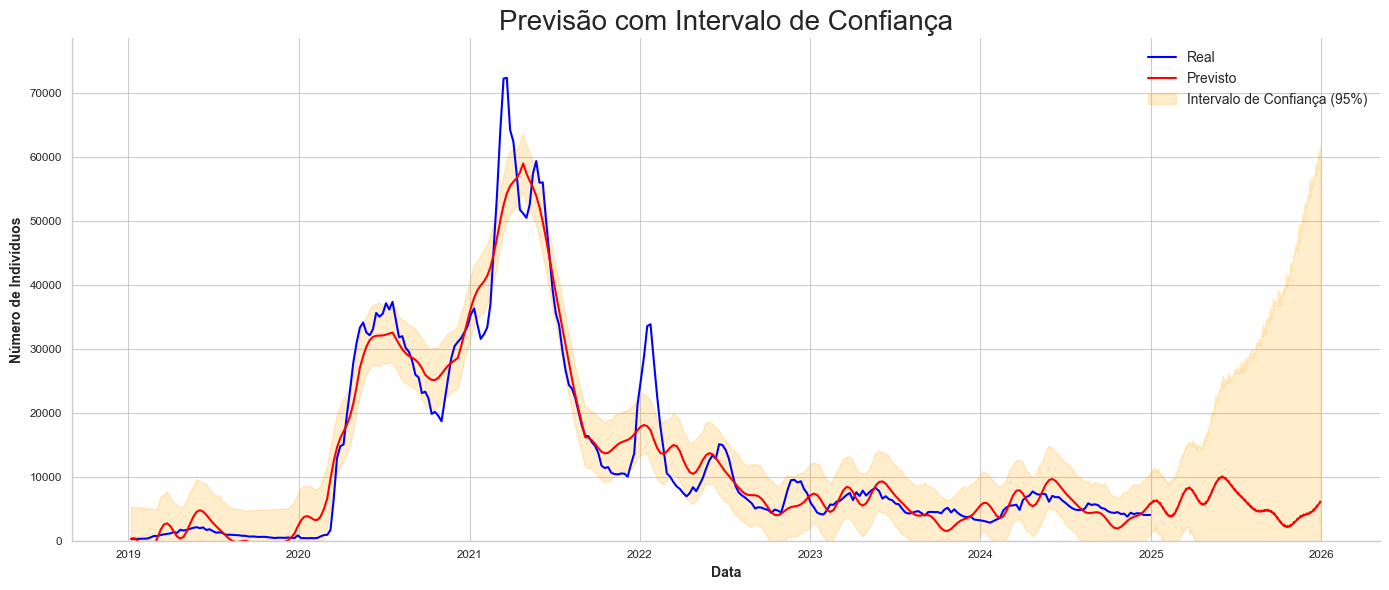

In [66]:
future2 = model.make_future_dataframe(periods=365)  # Prever 1 ano à frente
forecast2 = model.predict(future2)

plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# Plotar dados reais
sns.lineplot(data=df, x='ds', y='y', label="Real", color='blue', linewidth=1.5)

# Plotar previsões (apenas positivas)
sns.lineplot(data=forecast2, x='ds', y='yhat', label="Previsto", color='red', linewidth=1.5)

# Preencher intervalo de confiança (80% e 95%)
plt.fill_between(
    forecast_filtered['ds'],
    forecast_filtered['yhat_lower'],
    forecast_filtered['yhat_upper'],
    color='orange',
    alpha=0.2,
    label="Intervalo de Confiança (95%)"
)

# Mostrar apenas valores positivos no eixo y
plt.ylim(bottom=0)
plt.title("Previsão com Intervalo de Confiança", fontsize=20)
plt.xlabel("Data")
plt.ylabel("Número de Indivíduos")
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()


In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Filtrar apenas as datas de teste (onde temos valores reais para comparação)
forecast_test = forecast[forecast['ds'].isin(val_df['ds'])]
forecast_test = forecast_test[forecast_test['yhat'] > 0]  # Manter só previsões positivas

# Calcular RMSE e MAPE
rmse = np.sqrt(mean_squared_error(val_df['y'], forecast_test['yhat']))
mape = mean_absolute_percentage_error(val_df['y'], forecast_test['yhat']) * 100  # Em %

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 1636.44
MAPE: 30.23%
